In [0]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21338563.06it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:03, 10246.38it/s]            
  1%|          | 16384/1648877 [00:00<00:13, 117340.02it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5362843.51it/s]                           
8192it [00:00, 131892.61it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
model = Model()
if cuda:
    model.cuda() # CUDA!
optimizer = optim.Adam(model.parameters(), lr=1e-3)    

In [0]:
EPOCHS = 15
losses = []

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().data)
#         losses.append(loss.cpu().data[0])        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.cpu().data), 
                end='')
    # Eval
    evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
    evaluate_y = Variable(test_loader.dataset.test_labels)
    if cuda:
        evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

    model.eval()
    output = model(evaluate_x[:,None,...])
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data,
        accuracy*100,
        end=''))

 Train Epoch: 1/15 [60000/60000 (100%)]	Loss: 1.486982	 Test Accuracy: 95.6200%


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


 Train Epoch: 2/15 [60000/60000 (100%)]	Loss: 1.485699	 Test Accuracy: 97.7800%
 Train Epoch: 3/15 [60000/60000 (100%)]	Loss: 1.461360	 Test Accuracy: 98.0800%
 Train Epoch: 4/15 [60000/60000 (100%)]	Loss: 1.476150	 Test Accuracy: 98.1600%
 Train Epoch: 5/15 [60000/60000 (100%)]	Loss: 1.477142	 Test Accuracy: 98.5100%
 Train Epoch: 6/15 [60000/60000 (100%)]	Loss: 1.474731	 Test Accuracy: 98.5400%
 Train Epoch: 7/15 [60000/60000 (100%)]	Loss: 1.491382	 Test Accuracy: 98.8000%
 Train Epoch: 8/15 [60000/60000 (100%)]	Loss: 1.463181	 Test Accuracy: 98.9900%
 Train Epoch: 9/15 [60000/60000 (100%)]	Loss: 1.466951	 Test Accuracy: 98.7200%
 Train Epoch: 10/15 [60000/60000 (100%)]	Loss: 1.461195	 Test Accuracy: 99.0100%
 Train Epoch: 11/15 [60000/60000 (100%)]	Loss: 1.471871	 Test Accuracy: 98.8700%
 Train Epoch: 12/15 [60000/60000 (100%)]	Loss: 1.461221	 Test Accuracy: 98.8100%
 Train Epoch: 13/15 [60000/60000 (100%)]	Loss: 1.487345	 Test Accuracy: 99.0300%
 Train Epoch: 14/15 [60000/60000 (10

In [0]:
# torch.save(model,os.path.join(save_path, 'cnn.pth'))
# torch.save(model.state_dict(), os.path.join(save_path, 'cnn_state.pth'))

In [0]:
save_path

'drive/My Drive/classification_images'

In [0]:
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.test_labels)
if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

model.eval()
output = model(evaluate_x[:,None,...])
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

print('Accuracy:', accuracy*100)

Accuracy: tensor(99.1000, dtype=torch.float64)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [0]:
import sklearn
from sklearn import metrics
sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())

NameError: ignored

In [0]:
# uploading the GAN trained model

save_path = 'drive/My Drive/classification_images'



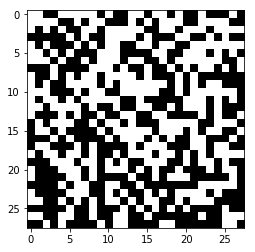

In [0]:
 z = torch.rand(10, 1, 28, 28) #.cuda()
 z[z<.5] = 0
 z[z>=.5] = 1
  
 plt.imshow(z[1].reshape(28,28), cmap = 'gray')

In [0]:
# black and white patterns

batch_size = 10000
all_size = 100000

stats = dict()
for i in range(10):
    stats[i] = 0
    
    
avgs = torch.zeros(100, 10, 28*28)

for kk in range(100):
  print(kk)
  
#   z = torch.rand(all_size, 1, 28, 28)*2 -1 #.cuda()
  z = torch.rand(all_size, 1, 28, 28) #.cuda()
#   z[z<.5] = 0
#   z[z<=.5] = 1
  
  z.cuda()
  #plt.imshow(z[1].reshape(28,28))


  all_preds = []
  all_idx = torch.ones(all_size, dtype = torch.uint8)
  for k in range(0,all_size, batch_size):
      y_pred = model(z[k:k+batch_size].cuda())
      #y_pred[y_pred < 0]= 0

      indices = torch.ones(y_pred.size(0), dtype = torch.uint8)
      indices[torch.mean(y_pred, dim =1)==0] = 0 

      all_idx[k:k+batch_size] = indices 
      pred = y_pred[indices==1].data.max(1)[1]

      all_preds.append(pred)

  pred = torch.cat(all_preds)

  for i in range(10):
    stats[i] += torch.sum(pred==i)
  
  z = z[all_idx]
  for i in range(10):
      a = torch.mean(z[pred==i] , dim=0) 
      avgs[kk, i] = a.reshape(28*28)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [0]:
batch_size = 10000
all_size = 100000

stats = dict()
for i in range(10):
    stats[i] = 0
    
    
avgs = torch.zeros(100, 10, 28*28)

for kk in range(100):
  print(kk)
  
#   z = torch.rand(all_size, 1, 28, 28)*2 -1 #.cuda()
  z = torch.rand(all_size, 1, 28, 28) #.cuda()
  
  z.cuda()
  #plt.imshow(z[1].reshape(28,28))


  all_preds = []
  all_idx = torch.ones(all_size, dtype = torch.uint8)
  for k in range(0,all_size, batch_size):
      y_pred = model(z[k:k+batch_size].cuda())
      #y_pred[y_pred < 0]= 0

      indices = torch.ones(y_pred.size(0), dtype = torch.uint8)
      indices[torch.mean(y_pred, dim =1)==0] = 0 

      all_idx[k:k+batch_size] = indices 
      pred = y_pred[indices==1].data.max(1)[1]

      all_preds.append(pred)

  pred = torch.cat(all_preds)

  for i in range(10):
    stats[i] += torch.sum(pred==i)
  
  z = z[all_idx]
  for i in range(10):
      a = torch.mean(z[pred==i] , dim=0) 
      avgs[kk, i] = a.reshape(28*28)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [0]:
z = torch.rand(1000000, 784)
grand_mean = torch.mean(z,dim=0)

In [0]:
# torch.nn.functional.softmax(a)

In [0]:
stats

{0: tensor(8477, device='cuda:0'),
 1: tensor(315, device='cuda:0'),
 2: tensor(114741, device='cuda:0'),
 3: tensor(36349, device='cuda:0'),
 4: tensor(37842, device='cuda:0'),
 5: tensor(12396, device='cuda:0'),
 6: tensor(731, device='cuda:0'),
 7: tensor(3253, device='cuda:0'),
 8: tensor(782547, device='cuda:0'),
 9: tensor(3349, device='cuda:0')}

In [0]:
grand_mean.shape

torch.Size([784])

In [0]:
b.data.max(1)[1]
b
a.shape

torch.Size([28, 28])

In [0]:
for i in range(10):
    print(torch.sum(pred==i))  


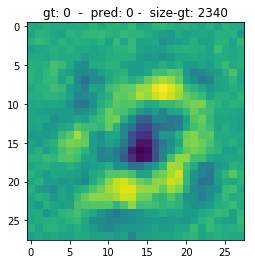

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


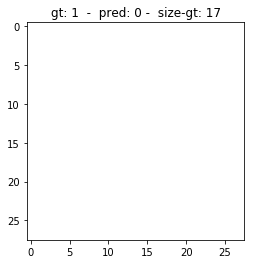

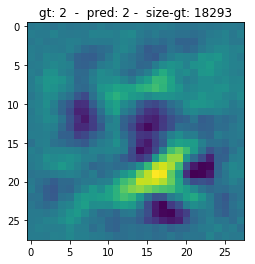

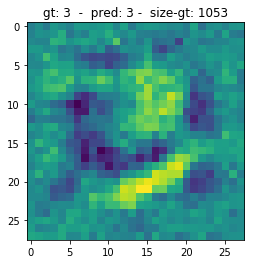

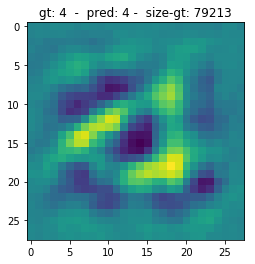

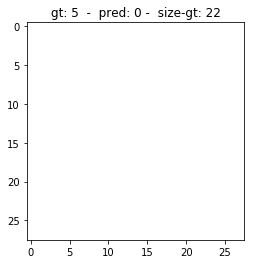

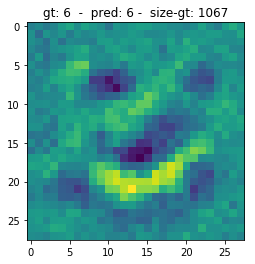

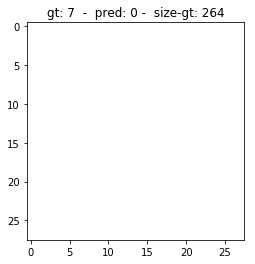

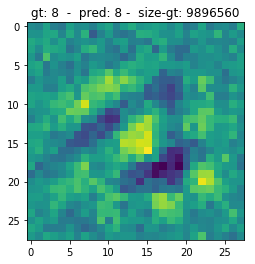

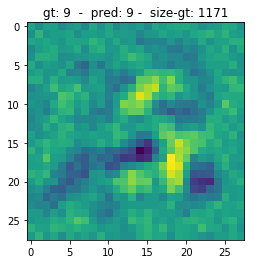

In [0]:
save_path = 'drive/My Drive/classification_images'
import os
dd = torch.mean(avgs, dim=0)
#dd = dd - grand_mean
for kk in range(10):
  
  fig = plt.figure()
  a = dd[kk]
  a = a.view(-1,28)
  b = model(a[None,None,...].cuda())

  #a = torch.nn.functional.log_softmax(a)# torch.nn.functional.softmax(a)
  c = b.data.max(1)[1]
  plt.title(f'gt: {str(kk)}  -  pred: {str(c.cpu().data[0].numpy())} -  size-gt: {stats[kk]}')  
  plt.imshow(a) #, cmap = 'gray')
  #fig.savefig(os.path.join(save_path, str(kk)+'-.png'))
  

In [0]:
#   
# - load the model
# - modulate the input
# - see how many are classified as the pattern

import os

model = Model()
if cuda:
    model.cuda() # CUDA!
    
model = torch.load(os.path.join(save_path, 'cnn.pth'))



In [0]:
import torch.nn.functional as F
def resize2d(img, size):
    return (F.adaptive_avg_pool2d(Variable(img,volatile=True), size)).data

  
from skimage import io, transform  
import sklearn
from sklearn import metrics


tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8,
        0, 8, 8, 8, 2, 8, 8, 8, 8, 8, 9, 8, 8, 4, 8, 8, 0, 8, 8, 8, 8, 8, 8, 8,
        4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 2, 4, 4, 8,
        8, 8, 2, 8], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')
tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8,
        0, 8, 8, 8, 2, 8, 8, 8, 8, 8, 9, 8, 8, 4, 8, 8, 0, 8, 8, 8, 8, 8, 8, 8,
        4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

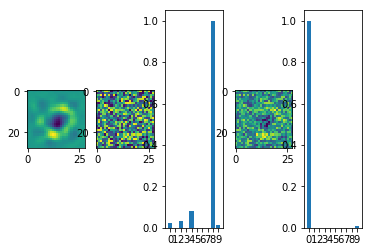

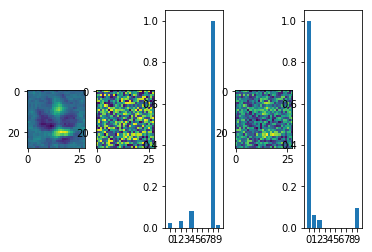

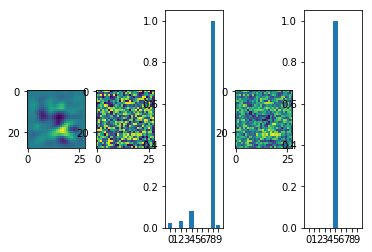

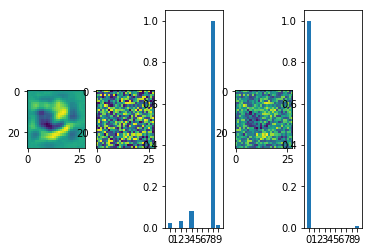

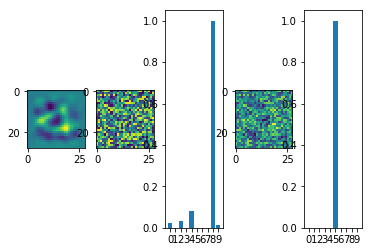

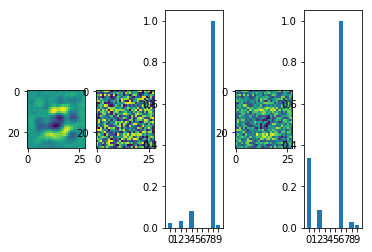

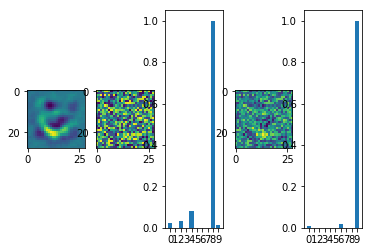

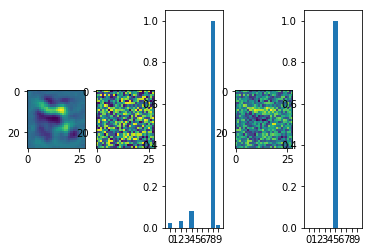

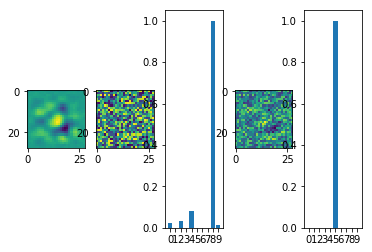

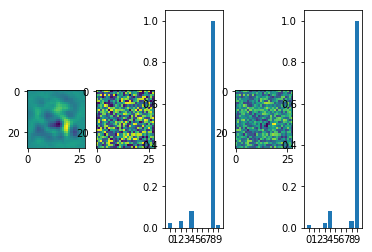

In [0]:
# load the zero image
objects = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

z = torch.rand(100, 1, 28, 28) #.cuda()

for i in range(10):

  pattern =  io.imread(os.path.join(save_path, str(i) + '-.png'))
  pattern = pattern[35:35+217,113:330,0]
  pattern = transform.resize(pattern, (28, 28))
  # pattern = torch.from_numpy(pattern)

  pattern = torch.from_numpy(pattern)
  pattern = pattern.type(torch.FloatTensor)

  plt.figure()
  plt.subplot(151)
  plt.imshow(pattern)


  plt.subplot(152)
  plt.imshow(torch.squeeze(z[0,...],0))

  y_pred = model(z.cuda())
  print(y_pred.data.max(1)[1])
  
  
  plt.subplot(153)
  freq = y_pred.data.max(1)[1].cpu()
  aa = numpy.histogram(freq.numpy()) 
  y_pos = np.arange(len(aa[0]))
  plt.bar(y_pos, aa[0]/aa[0].max())
  plt.xticks(y_pos, objects)

  
  z_new = z + (.9*pattern)

  plt.subplot(154)
  plt.imshow(torch.squeeze(z_new[0,...],0))

  y_pred = model(z_new.cuda())
#   print(y_pred.data.max(1)[1])
  
  plt.subplot(155)
  freq = y_pred.data.max(1)[1].cpu()
  aa = numpy.histogram(freq.numpy()) 
  y_pos = np.arange(len(aa[0]))
  plt.bar(y_pos, aa[0]/aa[0].max())
  plt.xticks(y_pos, objects)
  print(y_pred.data.max(1)[1])
#   plt.bar()
#   plt.hist(y_pred.data.max(1)[1].cpu())


In [0]:
digits = next(iter(train_loader))


In [0]:
from torchvision import transforms, datasets
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5), (.5))         
#          transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    transform = transforms.Compose([
        transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])    
    
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=transform, download=True)




In [0]:
train_loader

AttributeError: ignored

tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 7, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')
tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

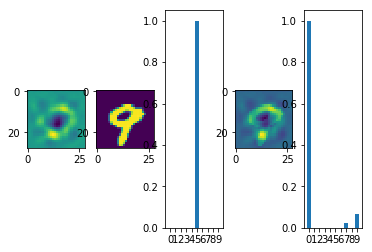

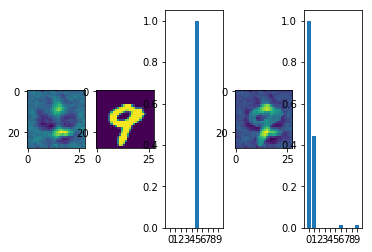

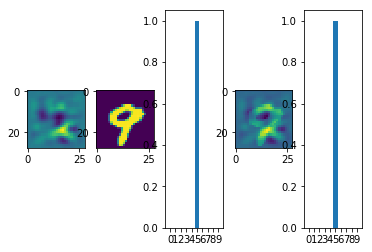

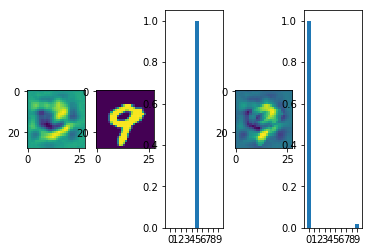

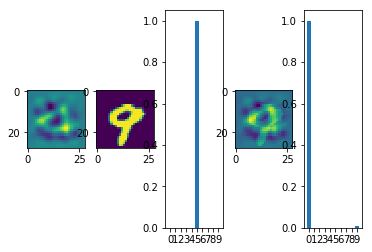

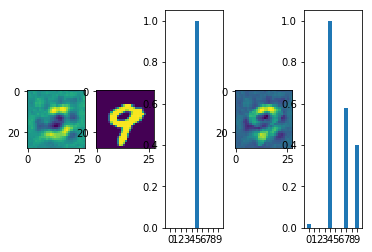

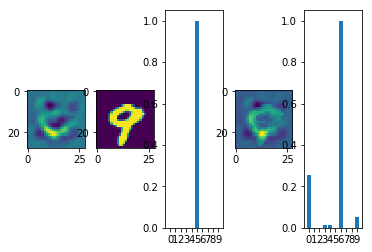

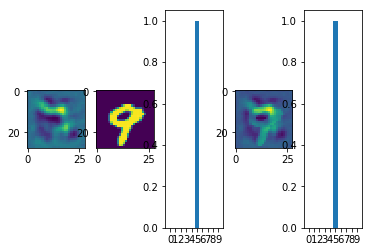

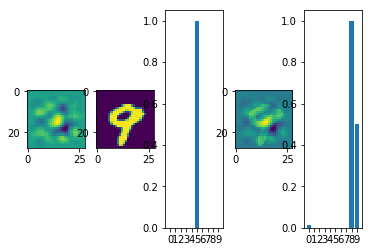

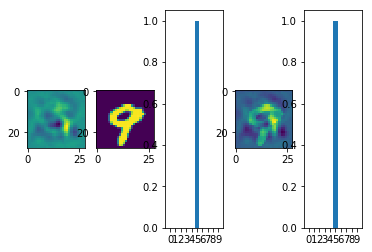

In [0]:
# ls 'drive/My Drive/classification_images'
# torch.squeeze(z[0,...],0).shape
# plt.hist(y_pred.data.max(1)[1].cpu())

objects = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
# evaluate_y = Variable(test_loader.dataset.test_labels)
# if cuda:
#     evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()


#digits = next(iter(train_loader))



# Load data
data = mnist_data()

tt = data.targets[data.targets==9]
dd = data.data[data.targets==9] 
data.targets = tt
data.data = dd
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True, drop_last =True)
# Num batches

z = next(iter(data_loader)) 


for i in range(10):

  pattern =  io.imread(os.path.join(save_path, str(i) + '-.png'))
  pattern = pattern[35:35+217,113:330,0]
  pattern = transform.resize(pattern, (28, 28))
  # pattern = torch.from_numpy(pattern)

  pattern = torch.from_numpy(pattern)
  pattern = pattern.type(torch.FloatTensor)

  plt.figure()
  plt.subplot(151)
  plt.imshow(pattern)

  z_old = (z[0] + 1)/2
  
  plt.subplot(152)
  plt.imshow(torch.squeeze(z_old[0,...],0))

  y_pred = model(z_old.cuda())
  print(y_pred.data.max(1)[1])
  
  
  plt.subplot(153)
  freq = y_pred.data.max(1)[1].cpu()
  aa = numpy.histogram(freq.numpy()) 
  y_pos = np.arange(len(aa[0]))
  plt.bar(y_pos, aa[0]/aa[0].max())
  plt.xticks(y_pos, objects)

  
  z_new = .3*z_old + pattern

  plt.subplot(154)
  plt.imshow(torch.squeeze(z_new[0,...],0))

  y_pred = model(z_new.cuda())
#   print(y_pred.data.max(1)[1])
  
  plt.subplot(155)
  freq = y_pred.data.max(1)[1].cpu()
  aa = numpy.histogram(freq.numpy()) 
  y_pos = np.arange(len(aa[0]))
  plt.bar(y_pos, aa[0]/aa[0].max())
  plt.xticks(y_pos, objects)
  print(y_pred.data.max(1)[1])
#   plt.bar()
#   plt.hist(y_pred.data.max(1)[1].cpu())

In [0]:
  z.min()

tensor(0.)

In [0]:
for i in range(10):
    print(torch.sum(pred==i))

tensor(236, device='cuda:0')
tensor(3, device='cuda:0')
tensor(1874, device='cuda:0')
tensor(160, device='cuda:0')
tensor(2689, device='cuda:0')
tensor(22, device='cuda:0')
tensor(44, device='cuda:0')
tensor(81, device='cuda:0')
tensor(93796, device='cuda:0')
tensor(98, device='cuda:0')


In [0]:
# ls
from google.colab import files
files.download('./*.png')


FileNotFoundError: ignored

In [0]:
ls drive/My\ Drive/classification_images


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


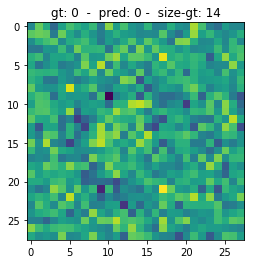

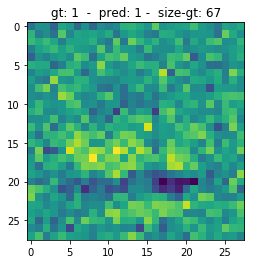

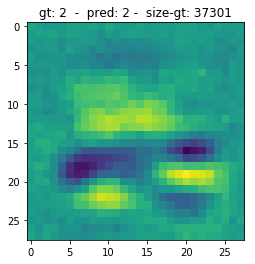

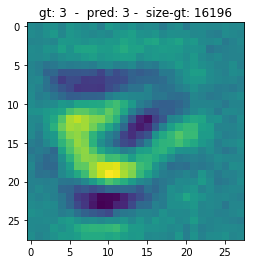

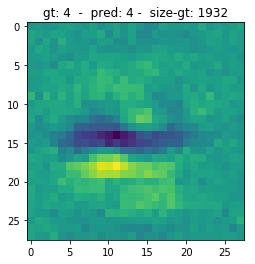

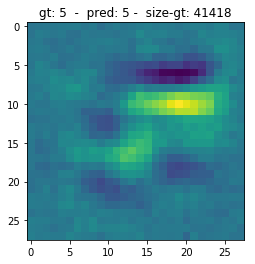

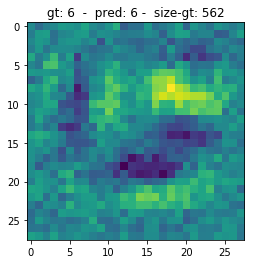

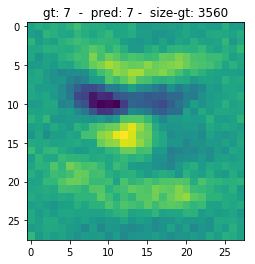

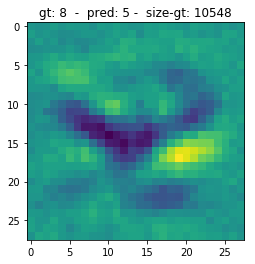

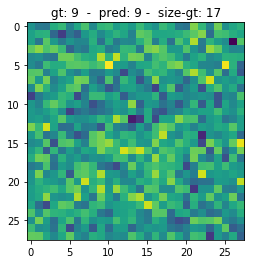

In [0]:
# z = z[all_idx]
pred = torch.cat(all_preds)
for i in range(10):
    plt.figure()
    a = torch.mean(z[pred==i] , dim=0) 
    a = a.view(-1,28)
    b = model(a[None,None,...].cuda())
    c = b.data.max(1)[1]
    plt.title(f'gt: {str(i)}  -  pred: {str(c.cpu().data[0].numpy())} -  size-gt: {z[pred==i].size(0)}')
    plt.imshow(1-a)

In [0]:
# for i in range(z.size(0)):
#   print(torch.max(data[1,0]))